In [1]:
#https://ieeexplore.ieee.org/document/10549889

In [2]:
!pip install openpyxl ssqueezepy pyts

Defaulting to user installation because normal site-packages is not writeable


In [3]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model, Sequential
from tensorflow.keras.applications import ResNet50
from ssqueezepy import cwt
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import butter, filtfilt
import pywt
import pyts
import matplotlib.pyplot as plt

2025-01-08 11:14:28.196747: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9360] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-08 11:14:28.196821: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-08 11:14:28.196858: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1537] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-08 11:14:28.206315: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
import keras.models
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns

In [5]:
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns


def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values



# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = np.dstack(loaded)
    return loaded

# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    # load all 9 files as a single array
    filenames = list()
    # total acceleration
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    # body acceleration
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    # body gyroscope
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    # load input data
    X = load_group(filenames, filepath)
    # load class output
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y


# load the dataset, returns train and test X and y elements
# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
    # load all train
    trainX, trainy = load_dataset_group('train', prefix + 'UCI HAR Dataset/')
    # load all test
    testX, testy = load_dataset_group('test', prefix + 'UCI HAR Dataset/')

    #zero-offset class values
    trainy = trainy - 1
    testy = testy - 1

    trainy_one_hot = to_categorical(trainy)
    testy_one_hot = to_categorical(testy)
    print(trainX.shape, trainy.shape, trainy_one_hot.shape, testX.shape, testy.shape, testy_one_hot.shape)
    return trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot

In [6]:
trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot = load_dataset()

(7352, 128, 9) (7352, 1) (7352, 6) (2947, 128, 9) (2947, 1) (2947, 6)


In [7]:
print("X train shape: ", trainX.shape)
print("Y train shape: ", trainy.shape)
print("Y train One hot shape: ", trainy_one_hot.shape)
print("X test shape: ", testX.shape)
print("Y test shape: ", testy.shape)
print("Y test One hot shape: ", testy_one_hot.shape)

X train shape:  (7352, 128, 9)
Y train shape:  (7352, 1)
Y train One hot shape:  (7352, 6)
X test shape:  (2947, 128, 9)
Y test shape:  (2947, 1)
Y test One hot shape:  (2947, 6)


In [8]:
print("0: Walking:" ,np.where(trainy == 0)[0].size)
print("1: WU:" ,np.where(trainy == 1)[0].size)
print("2: WD:" ,np.where(trainy == 2)[0].size)
print("3: Sitting:" ,np.where(trainy == 3)[0].size)
print("4: Standing:" ,np.where(trainy == 4)[0].size)
print("5: Laying:" ,np.where(trainy == 5)[0].size)

0: Walking: 1226
1: WU: 1073
2: WD: 986
3: Sitting: 1286
4: Standing: 1374
5: Laying: 1407


In [9]:
unique, counts = np.unique(trainy, return_counts=True)
print ("Train data label statistics::")
print (np.asarray((unique, counts)).T)

unique, counts = np.unique(testy, return_counts=True)
print ("Test data label statistics::")
print (np.asarray((unique, counts)).T)

Train data label statistics::
[[   0 1226]
 [   1 1073]
 [   2  986]
 [   3 1286]
 [   4 1374]
 [   5 1407]]
Test data label statistics::
[[  0 496]
 [  1 471]
 [  2 420]
 [  3 491]
 [  4 532]
 [  5 537]]


In [10]:
X_train_all = trainX   # at this stage, the data includes both dynamic and static HAR data
y_train_all = trainy

X_test_all = testX
y_test_all = testy

In [11]:
import random

static_1 = np.where(trainy == 3)[0]
static_2 = np.where(trainy == 4)[0]
static_3 = np.where(trainy == 5)[0]
static = np.concatenate([static_1, static_2, static_3])
static_list = static.tolist()

# Shuffle dynamic data index
r = random.random()
random.shuffle(static_list, lambda: r)

static = np.array(static)

trainX = X_train_all[static]
trainy = y_train_all[static]

/tmp/ipykernel_307/2481253413.py:11: DeprecationWarning: The *random* parameter to shuffle() has been deprecated
since Python 3.9 and will be removed in a subsequent version.
  random.shuffle(static_list, lambda: r)


In [12]:
static_1 = np.where(testy == 3)[0]
static_2 = np.where(testy == 4)[0]
static_3 = np.where(testy == 5)[0]
static = np.concatenate([static_1, static_2, static_3])
static_list = static.tolist()

r = random.random()
random.shuffle(static_list, lambda: r)

static = np.array(static_list)

testX = X_test_all[static]
testy = y_test_all[static]

/tmp/ipykernel_307/4217821953.py:8: DeprecationWarning: The *random* parameter to shuffle() has been deprecated
since Python 3.9 and will be removed in a subsequent version.
  random.shuffle(static_list, lambda: r)


In [13]:
unique, counts = np.unique(trainy, return_counts=True)
print ("Train data label statistics::")
print (np.asarray((unique, counts)).T)

unique, counts = np.unique(testy, return_counts=True)
print ("Test data label statistics::")
print (np.asarray((unique, counts)).T)

Train data label statistics::
[[   3 1286]
 [   4 1374]
 [   5 1407]]
Test data label statistics::
[[  3 491]
 [  4 532]
 [  5 537]]


In [14]:
trainy = trainy - 3
testy = testy - 3
trainy_one_hot = to_categorical(trainy)
testy_one_hot = to_categorical(testy)

In [15]:
print("X train shape: ", trainX.shape)
print("Y train shape: ", trainy.shape)
print("Y train One hot shape: ", trainy_one_hot.shape)
print("X test shape: ", testX.shape)
print("Y test shape: ", testy.shape)
print("Y test One hot shape: ", testy_one_hot.shape)

X train shape:  (4067, 128, 9)
Y train shape:  (4067, 1)
Y train One hot shape:  (4067, 3)
X test shape:  (1560, 128, 9)
Y test shape:  (1560, 1)
Y test One hot shape:  (1560, 3)


In [16]:
# trainX, valX, trainy, valy = train_test_split(trainX, trainy,test_size=0.3)

# Standard Scaling

In [17]:
from sklearn.preprocessing import StandardScaler

# Standard Scaling
scaler_std = StandardScaler()

# 데이터 평탄화 후 스케일링
trainX_flat_std = trainX.reshape(-1, 9)
testX_flat_std = testX.reshape(-1, 9)

trainX_std = scaler_std.fit_transform(trainX_flat_std)
testX_std = scaler_std.transform(testX_flat_std)

# 원래 형태로 변환
trainX_std = trainX_std.reshape(4067, 128, 9)
testX_std = testX_std.reshape(1560, 128, 9)

print("Standard Scaled trainX shape:", trainX_std.shape)
print("Standard Scaled testX shape:", testX_std.shape)

Standard Scaled trainX shape: (4067, 128, 9)
Standard Scaled testX shape: (1560, 128, 9)


In [18]:
trainX_transformer = trainX_std.copy()
testX_transformer = testX_std.copy()

In [19]:
# from tensorflow.keras import layers, models
# import tensorflow as tf

# def reshape_to_transformer_input(data):
#     """
#     데이터 형태를 Transformer 입력에 맞게 조정
#     Input: (None, 128, 9)
#     Output: (None, 128, 256)
#     """
#     input_layer = layers.Input(shape=(128, 9))
#     x = layers.Conv1D(filters=256, kernel_size=3, strides=1, padding='same')(input_layer)
#     x = layers.LayerNormalization()(x)
    
#     model = tf.keras.Model(inputs=input_layer, outputs=x)
#     return model(data).numpy()

# # 데이터 변환
# trainX_transformer = reshape_to_transformer_input(trainX_minmax)
# testX_transformer = reshape_to_transformer_input(testX_minmax)

# print("Transformer-ready trainX shape:", trainX_transformer.shape)  # (4067, 128, 256)
# print("Transformer-ready testX shape:", testX_transformer.shape)    # (1560, 128, 256)

# ResNet 입력 형태 변환

In [20]:
# ResNet 입력 형태로 변환
trainX_resnet = trainX_std[..., np.newaxis]  # 마지막 축에 채널 추가
testX_resnet = testX_std[..., np.newaxis]    # 마지막 축에 채널 추가

print("ResNet trainX shape:", trainX_resnet.shape)
print("ResNet testX shape:", testX_resnet.shape)

ResNet trainX shape: (4067, 128, 9, 1)
ResNet testX shape: (1560, 128, 9, 1)


# DOLG Model

In [21]:
import tensorflow as tf
from tensorflow.keras import layers

class GeneralizedMeanPooling2D(layers.Layer):
    def __init__(self, init_norm=3.0, normalize=False, epsilon=1e-4, **kwargs):
        self.init_norm = init_norm
        self.normalize = normalize
        self.epsilon = epsilon
        super(GeneralizedMeanPooling2D, self).__init__(**kwargs)

    def build(self, input_shape):
        self.p = self.add_weight(
            name="norms",
            shape=(input_shape[-1],),
            initializer=tf.keras.initializers.Constant(self.init_norm),
            trainable=True
        )
        super(GeneralizedMeanPooling2D, self).build(input_shape)

    def call(self, inputs):
        x = tf.abs(tf.maximum(self.epsilon, inputs))  # 안정성을 위해 epsilon 추가
        x = tf.pow(x, self.p)  # p승
        x = tf.reduce_mean(x, axis=[1, 2], keepdims=False)  # 평균
        x = tf.pow(x, 1.0 / self.p)  # 1/p 승
        
        if self.normalize:
            x = tf.nn.l2_normalize(x, axis=1)
        
        return x

    def get_config(self):
        config = {
            'init_norm': self.init_norm,
            'normalize': self.normalize,
            'epsilon': self.epsilon
        }
        base_config = super(GeneralizedMeanPooling2D, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


In [22]:
from tensorflow.keras import layers

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0.3):
    x = inputs
    for _ in range(4):  # 4개의 Transformer Block 반복
        # Multi-Head Attention
        x_attn = layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
        x = layers.Add()([x, x_attn])
        x = layers.LayerNormalization(epsilon=1e-3)(x)
        
        # Feed-Forward Network
        x_ff = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
        x_ff = layers.Dropout(dropout)(x_ff)
        x_ff = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x_ff)
        x = layers.Add()([x, x_ff])
        x = layers.LayerNormalization(epsilon=1e-3)(x)
    
    return x


In [23]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling1D, Dense, Lambda

def build_transformer_model(input_shape):
    inputs = Input(shape=input_shape)
    x = transformer_encoder(inputs, head_size=64, num_heads=4, ff_dim=128, dropout=0.3)
    x = GlobalAveragePooling1D()(x)
    outputs = Dense(128, activation='relu')(x)
    return Model(inputs, outputs, name="TransformerEncoder")


In [24]:
def resnet_block(inputs, filters, kernel_size=3, strides=1):
    x = inputs
    for _ in range(4):  # 4개의 ResNet Block 반복
        shortcut = x
        x = layers.Conv2D(filters, kernel_size, strides=strides, padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)
        x = layers.Conv2D(filters, kernel_size, strides=1, padding='same')(x)
        x = layers.BatchNormalization()(x)
        
        if shortcut.shape[-1] != x.shape[-1]:
            shortcut = layers.Conv2D(filters, kernel_size=1, strides=strides, padding='same')(shortcut)
            shortcut = layers.BatchNormalization()(shortcut)
        
        x = layers.Add()([x, shortcut])
        x = layers.ReLU()(x)
    
    return x


In [25]:
def build_resnet_model_with_gem(input_shape):
    inputs = tf.keras.layers.Input(shape=input_shape)
    
    # ResNet Block 반복
    x = resnet_block(inputs, filters=32)
    x = resnet_block(x, filters=64)
    x = resnet_block(x, filters=128)
    x = resnet_block(x, filters=256)
    x = layers.Dropout(0.3)(x)
    
    # GeM 적용
    x = GeneralizedMeanPooling2D()(x)
    
    # Dense Layer 추가
    outputs = layers.Dense(128, activation='relu')(x)
    
    return tf.keras.Model(inputs, outputs, name="ResNetEncoderWithGeM")


In [26]:
import tensorflow as tf
from tensorflow.keras import layers

class OrthogonalFusion(layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(name='OrthogonalFusion', **kwargs)
        self.local_dense = layers.Dense(128, activation='relu')
        self.global_dense = layers.Dense(128, activation='relu')
        self.fusion_dense = layers.Dense(128, activation='relu')
        self.concat = layers.Concatenate()

    def call(self, inputs):
        local_feat, global_feat = inputs
        local_feat = self.local_dense(local_feat)
        global_feat = self.global_dense(global_feat)
        fused = self.concat([local_feat, global_feat])
        return self.fusion_dense(fused)

In [29]:
from tensorflow.keras.layers import Input, Dense, Dropout, Lambda
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K

def build_dolg_model_with_l2_norm(transformer_input_shape, resnet_input_shape, num_classes):
    # 입력 레이어
    transformer_input = Input(shape=transformer_input_shape, name='Transformer_Input')
    resnet_input = Input(shape=resnet_input_shape, name='ResNet_Input')
    
    # Transformer Branch
    transformer_output = build_transformer_model(transformer_input_shape)(transformer_input)
    transformer_output = Lambda(lambda x: K.l2_normalize(x, axis=-1))(transformer_output)
    
    # ResNet Branch
    resnet_output = build_resnet_model_with_gem(resnet_input_shape)(resnet_input)
    resnet_output = Lambda(lambda x: K.l2_normalize(x, axis=-1))(resnet_output)
    
    # Orthogonal Fusion
    fusion_output = OrthogonalFusion()([transformer_output, resnet_output])
    fusion_output = Dropout(0.3)(fusion_output)
    fusion_output = Dense(128, activation='relu')(fusion_output)
    fusion_output = Lambda(lambda x: K.l2_normalize(x, axis=-1))(fusion_output)
    
    # Classifier
    outputs = Dense(num_classes, activation='softmax')(fusion_output)
    
    # 모델 생성
    model = Model(inputs=[transformer_input, resnet_input], outputs=outputs, name='DOLG_Model_with_L2_Norm')
    return model

In [30]:
# 하이퍼파라미터 설정
num_classes = 3

# DOLG 모델 구축
dolg_model = build_dolg_model_with_l2_norm((128, 9), (128, 9, 1), num_classes)

# 모델 컴파일
dolg_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3, clipvalue=1.0),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# 모델 요약
dolg_model.summary()


Model: "DOLG_Model_with_L2_Norm"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Transformer_Input (InputLa  [(None, 128, 9)]             0         []                            
 yer)                                                                                             
                                                                                                  
 ResNet_Input (InputLayer)   [(None, 128, 9, 1)]          0         []                            
                                                                                                  
 TransformerEncoder (Functi  (None, 128)                  51160     ['Transformer_Input[0][0]']   
 onal)                                                                                            
                                                                            

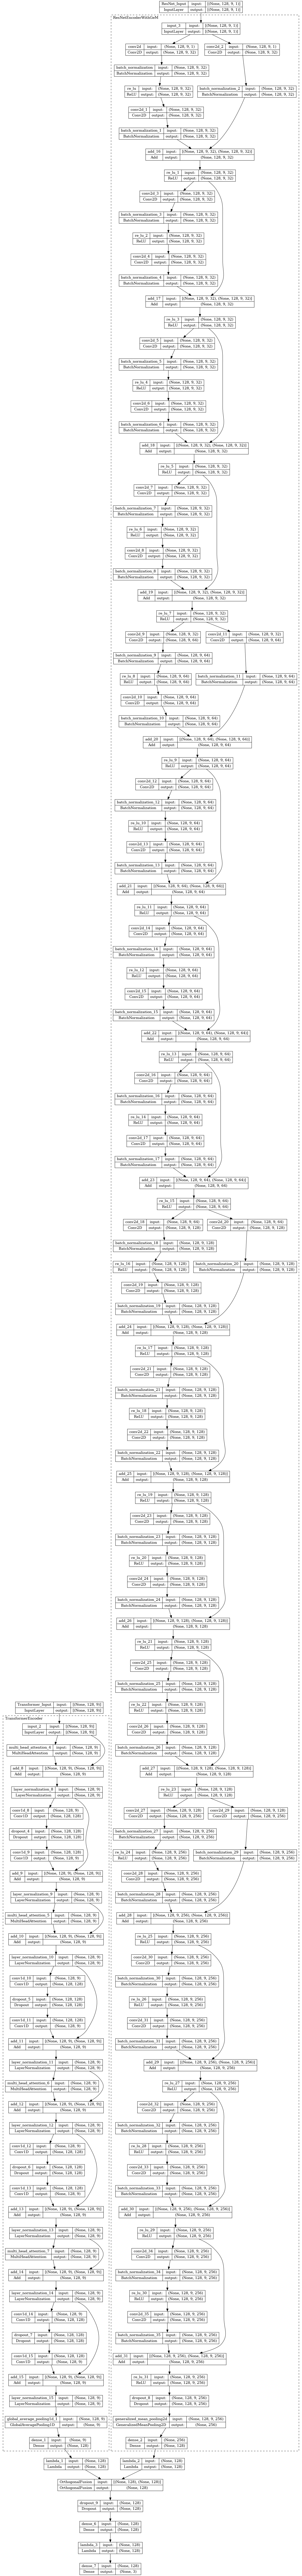

In [31]:
from tensorflow.keras.utils import plot_model

# 모델 시각화
plot_model(
    dolg_model,                   # 학습에 사용된 모델
    to_file="model_plot.png",  # 저장할 파일 이름
    show_shapes=True,         # 각 레이어의 출력 텐서 모양 표시
    show_layer_names=True,    # 레이어 이름 표시
    expand_nested=True,       # 중첩된 모델 (서브모델) 시각화
    dpi=96                    # 해상도 설정
)

In [32]:
trainX_transformer.shape

(4067, 128, 9)

In [33]:
trainX_resnet.shape

(4067, 128, 9, 1)

In [34]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.utils import class_weight
from tensorflow.keras.callbacks import LearningRateScheduler

def lr_schedule(epoch, lr):
    if epoch < 5:
        return lr
    return lr * tf.math.exp(-0.05)  # 지수 감소

lr_scheduler = LearningRateScheduler(lr_schedule)

# ReduceLROnPlateau 설정
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  # 검증 손실 기준으로 동작
    factor=0.5,          # 학습률 감소 비율 (50% 감소)
    patience = 5,          # 개선되지 않을 경우 5 Epoch 후 학습률 감소
    min_lr=1e-6          # 학습률의 하한선
)

# EarlyStopping 설정
early_stopping = EarlyStopping(
    monitor='val_loss',     # 검증 손실 기준으로 조기 종료
    patience=10,            # 개선되지 않을 경우 10 Epoch 후 종료
    restore_best_weights=True  # 가장 좋은 가중치로 복원
)

# # 클래스 가중치 계산
# class_weights = class_weight.compute_class_weight(
#     class_weight='balanced',
#     classes=np.unique(np.argmax(trainy_one_hot, axis=1)),
#     y=np.argmax(trainy_one_hot, axis=1)
# )

# class_weights = {i: w for i, w in enumerate(class_weights)}
# print("Class Weights:", class_weights)

# 콜백 리스트
callbacks = [early_stopping, reduce_lr, lr_scheduler]

# 모델 학습
history = dolg_model.fit(
    [trainX_transformer, trainX_resnet],  # 입력 데이터
    trainy_one_hot,                       # 레이블
    validation_split=0.25,                # 검증 데이터 비율
    epochs=100,                          # 최대 Epoch 수
    batch_size=12,                       # 배치 사이즈
    callbacks=callbacks,                  # 콜백 리스트 추가
#     class_weight=class_weights
)


Epoch 1/100


2025-01-08 11:17:07.052863: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1021] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inDOLG_Model_with_L2_Norm/ResNetEncoderWithGeM/dropout_8/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-01-08 11:17:09.093953: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907
2025-01-08 11:17:11.532526: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f060905c2c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-01-08 11:17:11.532575: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): CUDA GPU, Compute Capability 8.0
2025-01-08 11:17:11.532583: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): CUDA GPU, Compute Capability 8.0
2025-01-08 11:17:11.537596: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling M

255/255 [==============================] - 46s 64ms/step - loss: 0.5453 - accuracy: 0.8413 - val_loss: 0.2419 - val_accuracy: 0.9715 - lr: 0.0010
Epoch 2/100
255/255 [==============================] - 13s 53ms/step - loss: 0.3955 - accuracy: 0.8659 - val_loss: 0.4194 - val_accuracy: 0.9125 - lr: 0.0010
Epoch 3/100
255/255 [==============================] - 13s 53ms/step - loss: 0.2885 - accuracy: 0.9079 - val_loss: 0.2323 - val_accuracy: 0.9440 - lr: 0.0010
Epoch 4/100
255/255 [==============================] - 14s 55ms/step - loss: 0.2428 - accuracy: 0.9118 - val_loss: 0.0803 - val_accuracy: 0.9853 - lr: 0.0010
Epoch 5/100
255/255 [==============================] - 13s 52ms/step - loss: 0.2271 - accuracy: 0.9239 - val_loss: 0.0389 - val_accuracy: 0.9951 - lr: 0.0010
Epoch 6/100
255/255 [==============================] - 14s 55ms/step - loss: 0.2134 - accuracy: 0.9246 - val_loss: 0.0369 - val_accuracy: 0.9921 - lr: 9.5123e-04
Epoch 7/100
255/255 [==============================] - 13s 5

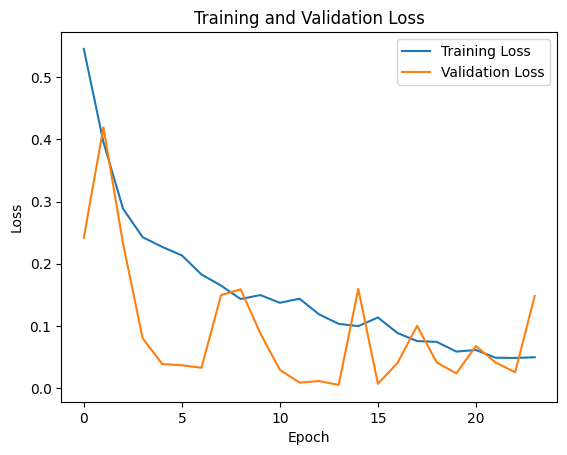

In [35]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

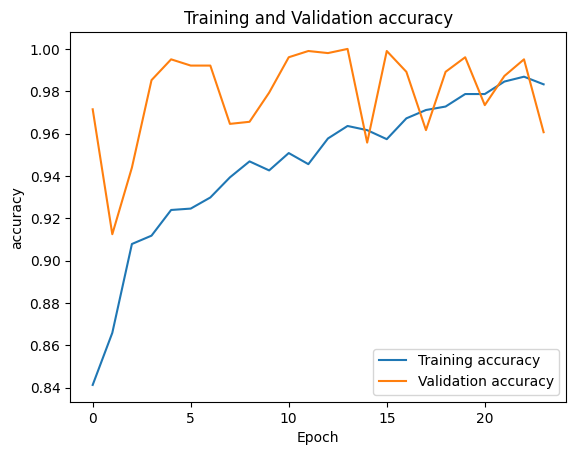

In [36]:
# Plot training and validation loss
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.legend()
plt.title('Training and Validation accuracy')
plt.show()

49/49 [==============================] - 3s 21ms/step
Classification Report:
              precision    recall  f1-score   support

     SITTING       0.97      0.88      0.92       491
    STANDING       0.90      0.98      0.94       532
      LAYING       1.00      1.00      1.00       537

    accuracy                           0.95      1560
   macro avg       0.96      0.95      0.95      1560
weighted avg       0.96      0.95      0.95      1560

Test Accuracy: 0.95


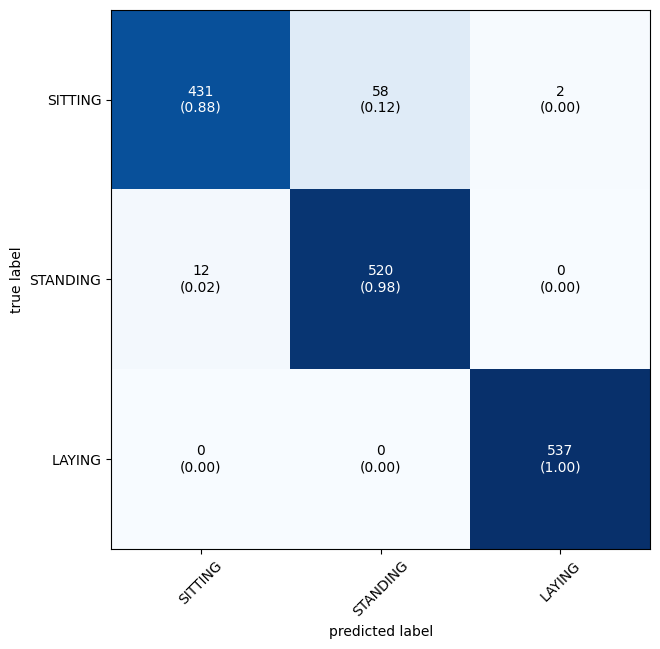

In [37]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import numpy as np

# 예측 수행
predy = dolg_model.predict([testX_transformer, testX_resnet])
predy = np.argmax(predy, axis=-1)  # 가장 확률이 높은 클래스를 선택

# 테스트 라벨 (One-Hot Encoding → 정수형 라벨 변환)
testy = np.argmax(testy_one_hot, axis=-1)  # 테스트 레이블 변환

# 라벨 정의
LABELS = ['SITTING', 'STANDING', 'LAYING']

# 혼동 행렬 생성
cm = confusion_matrix(testy, predy)

# 혼동 행렬 시각화
plot_confusion_matrix(conf_mat=cm, class_names=LABELS, show_normed=True, figsize=(7,7))

# 성능 보고서 출력
print("Classification Report:")
print(classification_report(testy, predy, target_names=LABELS))

# 정확도 출력
accuracy = accuracy_score(testy, predy)
print(f"Test Accuracy: {accuracy:.2f}")


In [38]:
from sklearn.metrics import precision_score, recall_score, f1_score

print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))

[[431  58   2]
 [ 12 520   0]
 [  0   0 537]]
0.9538461538461539
0.9535911552052108
              precision    recall  f1-score   support

           0       0.97      0.88      0.92       491
           1       0.90      0.98      0.94       532
           2       1.00      1.00      1.00       537

    accuracy                           0.95      1560
   macro avg       0.96      0.95      0.95      1560
weighted avg       0.96      0.95      0.95      1560

